In [1]:
import os

import joblib
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, Dense, Dropout, GlobalAveragePooling1D, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from matplotlib import pyplot as plt
print(os.listdir("../data"))
import warnings

warnings.filterwarnings('ignore')

['IMDB Dataset.csv']


In [2]:
models_path = "../models/"
X_train, X_test, y_train, y_test = joblib.load(models_path + "split_data.pkl")
tokenizer = joblib.load(models_path + "artifacts/tokenizer.pkl")

In [3]:
tokenizer.fit_on_texts(X_train)

In [4]:
# Text → sequence
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [5]:
# Padding
MAX_LEN = 200

X_train_pad = pad_sequences(
    X_train_seq,
    maxlen=MAX_LEN,
    padding="post",
    truncating="post"
)

X_test_pad = pad_sequences(
    X_test_seq,
    maxlen=MAX_LEN,
    padding="post",
    truncating="post"
)

In [6]:
y_train_num = y_train.map({'positive': 1, 'negative': 0})
y_test_num = y_test.map({'positive': 1, 'negative': 0})

In [7]:
model = Sequential([
    Embedding(
        input_dim=30000,
        output_dim=128,
        input_length=MAX_LEN
    ),
    Dropout(0.3),

    Conv1D(
        filters=128,
        kernel_size=3,
        activation='relu'
    ),
    Dropout(0.3),

    GlobalAveragePooling1D(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

In [8]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Show progress bar
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.pbar = tqdm(total=self.epochs, desc='Training Progress')

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        self.pbar.set_postfix(val_loss=logs.get('val_loss'), val_acc=logs.get('val_accuracy'))

    def on_train_end(self, logs=None):
        self.pbar.close()

In [11]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

In [12]:
cnn_model = model.fit(
    X_train_pad, y_train_num,
    validation_split=0.1,
    epochs=20,
    batch_size=128,
    callbacks=[early_stop, TQDMProgressBar()])


Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
280/282 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6597 - loss: 0.5793

Training Progress:   5%|▌         | 1/20 [00:06<02:05,  6.60s/it, val_acc=0.881, val_loss=0.291]

282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.7719 - loss: 0.4532 - val_accuracy: 0.8805 - val_loss: 0.2911
Epoch 2/20
280/282 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9113 - loss: 0.2374

Training Progress:  10%|█         | 2/20 [00:12<01:47,  5.97s/it, val_acc=0.886, val_loss=0.278]

282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9106 - loss: 0.2369 - val_accuracy: 0.8860 - val_loss: 0.2781
Epoch 3/20
280/282 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9446 - loss: 0.1600

Training Progress:  15%|█▌        | 3/20 [00:22<02:15,  7.97s/it, val_acc=0.883, val_loss=0.304]

282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9416 - loss: 0.1660 - val_accuracy: 0.8835 - val_loss: 0.3038
Epoch 4/20
280/282 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9640 - loss: 0.1100

Training Progress:  20%|██        | 4/20 [00:28<01:52,  7.05s/it, val_acc=0.879, val_loss=0.359]

282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9618 - loss: 0.1157 - val_accuracy: 0.8795 - val_loss: 0.3589


Training Progress:  20%|██        | 4/20 [00:28<01:52,  7.03s/it, val_acc=0.879, val_loss=0.359]


- The accuracy on the Train set is higher than the Validation set
- CNN Deep Learning model is starting to show slightly overfitting
- Compared to Base line DL model, the accuracy on train is 0.96 higher and the validation is slightly higher


In [13]:
y_pred_prob = model.predict(X_test_pad)
y_val_pred = (y_pred_prob > 0.5).astype(int)
y_val_pred


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[0],
       [0],
       [1],
       ...,
       [0],
       [1],
       [0]], shape=(10000, 1))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      5000
           1       0.89      0.89      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



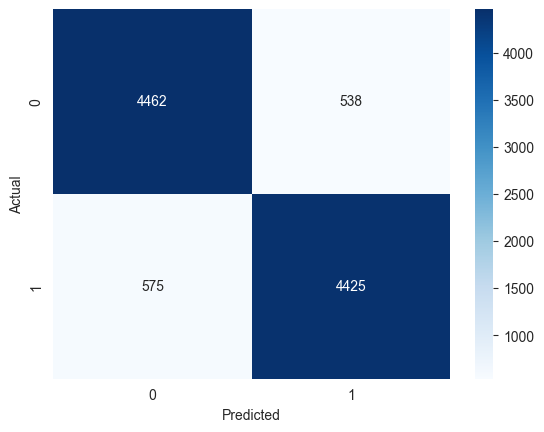

In [15]:
print(classification_report(y_test_num, y_val_pred))
cm = confusion_matrix(y_test_num, y_val_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

- On the test set it is not difference than base line DL model

# Day 7 – CNN
- On test set the Logistic Regression have slightly higher accuracy score
- CNN DL Model like baseline DL model has slightly overfitting
